Universidade Federal do Rio Grande do Sul (UFRGS)   
Programa de Pós-Graduação em Engenharia Civil (PPGEC)   

# PEC00025: Introduction to Vibration Theory


## Test P2 (2022/1): Discrete and continuous mdof systems

---

**NAME:** <br/>
**CARD:** 


#### Instruções

1. Entregar a resolução da prova em arquivo único, com no máximo 10Mb, até às 24h de hoje, 25 de maio de 2022.
2. Recomenda-se verificar atentamente se todas as folhas da resolução foram incluídas no arquivo gerado, pois não serão aceitas entregas posteriores.
3. Na primeira folha do arquivo deve constar claramente o NOME e o cartão de MATRÍCULA.
4. A consulta ao material de estudo e o uso do computador para cálculos são LIVRES.
5. A prova deve ser realizada INDIVIDUALMENTE, sem recorrer ao auxílio de colegas ou outras pessoas! Caso se verifique o descumprimento desta regra, todos os envolvidos na fraude terão a nota da prova zerada.


In [1]:
# Importing Python modules required for this notebook
# (this cell must be executed with "shift+enter" before any other Python cell)

import numpy as np
import matplotlib.pyplot as plt
import pickle as pk
import scipy.linalg as sc

from MRPy import MRPy


In [2]:
def vibration_modes(K, M):

# Uses scipy to solve the standard eigenvalue problem
    w2, Phi = sc.eig(K, M)

# Ensure ascending order of eigenvalues
    iw  = w2.argsort()
    w2  = w2[iw]
    Phi = Phi[:,iw]

# Eigenvalues to vibration frequencies
    wk  = np.sqrt(np.real(w2)) 
    fk  = wk/2/np.pi

    return fk, wk, Phi


## Questão 1

Um cabo com comportamento elástico linear é disposto horizontalmente.
O cabo tem comprimento total $L = 6{\rm m}$, rigidez axial $EA = 4000{\rm kN}$ 
e duas massas $m = 20{\rm kg}$ fixadas nos terços. 
O cabo tem uma protensão inicial $T_0 = 20{\rm kN}$. 
O amortecimento do sistema é $\zeta = 0.01$ (razão do crítico).
A rigidez à flexão bem como a massa do cabo são desprezáveis.
A aceleração da gravidade no local é $g = 9.81{\rm m/s^2}$.
Os dois graus de liberdade considerados são os deslocamentos verticais das
duas massas, $u_1(t)$ e $u_2(t)$.

<img src="resources/tests/PEC00025A_221_P2_Q1.jpg" alt="Question 1" width="680px"/>


### Solução

Admitindo-se uma condição de pequenos deslocamentos, calcule os modos de vibração e as respectivas frequências naturais de vibração livre do sistema. 


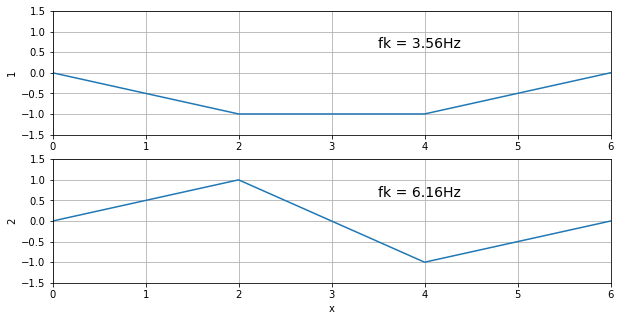

In [3]:
L   = 6.0
m   = 20.
T0  = 20000. 

k   = 6*T0/L

K1  = np.array([[k,  -k/2],[-k/2,  k]])
M1  = np.array([[m,   0  ],[ 0,    m]])

fk1, wk1, Phi1 = vibration_modes(K1, M1)

f1  = plt.figure(1, figsize=(10,5))
x   = np.arange(0, 8, 2)

for k in range(2):
    qk = np.zeros(4)
    qk[1:-1] = Phi1[:,k]
    qk /= np.max(np.abs(qk))   # adjust scale for unity amplitude
    
    plt.subplot(2,1,k+1)
    plt.plot(x, qk)
    
    plt.xlim( 0.0, 6.0);
    plt.ylim(-1.5, 1.5);  plt.ylabel(str(k+1));
    plt.text(3.5, 0.6, 'fk = {0:4.2f}Hz'.format(fk1[k]), fontsize=14);
    plt.grid(True)

plt.xlabel('x');


## Questão 2

No grau de liberdade $u_1(t)$ do problema anterior é aplicada uma carga transiente, 
$F_1(t)$, dada pela função abaixo, com amplitude $F_0 = 500{\rm N}$ e duração 
$T_{\rm d} = 0.1{\rm s}$. A variável $\tau$ representa o tempo adimensionalizado 
por $T_{\rm d}$.

<img src="resources/tests/PEC00025A_221_P2_Q2.jpg" alt="Question 2" width="480px"/>  


Desconsiderando a parcela estática da resposta (devida ao peso próprio), e considerando todos os modos de vibração, apresente o deslocamento $u_1(t)$ como uma função do tempo.
Indique a amplitude e o instante no tempo em que o máximo deslocamento é atingido.


### Solução

#### Método 1: por superposição modal simulando o carregamento

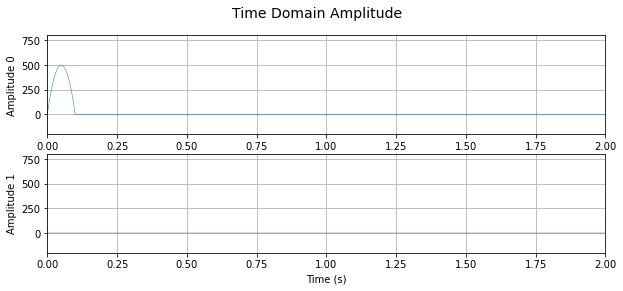

In [4]:
# Simulação das forças NODAIS

N   = 8192
Td  = 0.1
F0  = 500.
t   = np.linspace(0, 20*Td, N)
τ   = t/Td
fs  = N/t[-1]

F1  = 4*F0*(τ - τ**2)
F1[t > Td] = 0.
F1  = MRPy(np.vstack((F1, np.zeros_like(F1))), fs=fs)

f2  = F1.plot_time(fig=2, figsize=(10,4), axis_t=[0, F1.Td, -200, 800]);


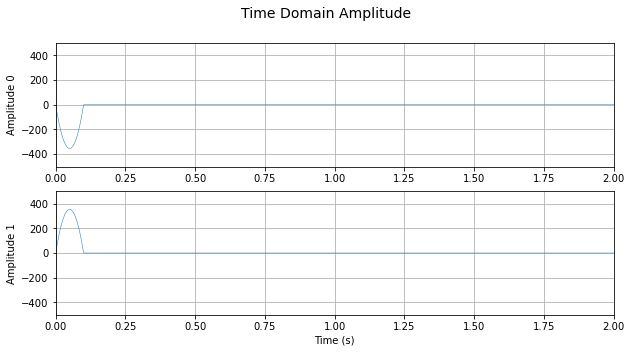

In [5]:
# Cálculo das forças MODAIS

zk1 = np.array([0.01, 0.01])
Mk1 = np.diag(np.dot(Phi1.T, np.dot(M1, Phi1)))
Kk1 = Mk1*(wk1**2)
Fk1 = MRPy(np.dot(Phi1.T, F1), fs=F1.fs)

f3  = Fk1.plot_time(fig=3, figsize=(10,5), axis_t=[0, F1.Td, -500, 500])
 

Deslocamento de pico da massa 1 é 0.0426m
Deslocamento de pico da massa 2 é 0.0378m


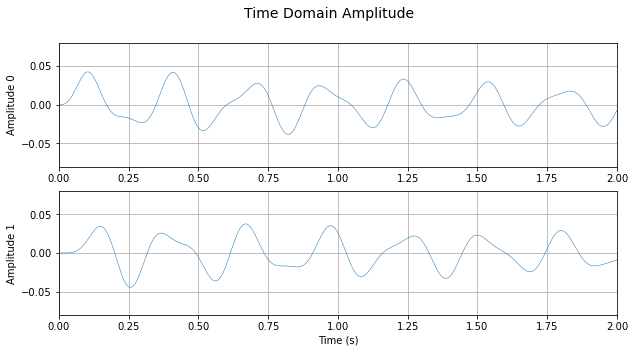

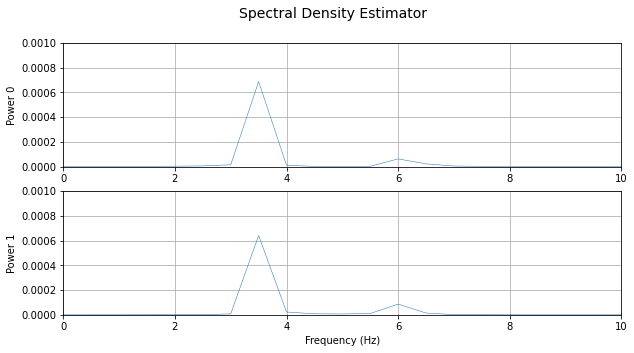

In [6]:
# Cálculo dos deslocamentos por superposição modal

# Mass division must be a matrix operation...
ak1 = MRPy(np.dot(np.diag(1/Mk1), Fk1), fs=Fk1.fs)

# ... and now solving
uk1 = ak1.sdof_Duhamel(fk1, zk1)             # modal space solution
uN1 = MRPy(np.dot(Phi1, uk1), fs=uk1.fs)     # back to nodal solution

# Resultado no domínio do tempo
f4  = uN1.plot_time(4, figsize=(10,5), axis_t=[0, uN1.Td, -0.08, 0.08])

# Resultado no domínio da frequência (para confirmar picos)
f5  = uN1.plot_freq(5, figsize=(10,5), axis_f=[0, 10, 0, 0.001])

up1 = uN1.max(axis=1)
print('Deslocamento de pico da massa 1 é {0:6.4f}m'.format(up1[0]))
print('Deslocamento de pico da massa 2 é {0:6.4f}m'.format(up1[1]))


#### Método 2: por condições iniciais (carga como impulso de Dirac)


In [7]:
I0  = 2*F0*Td/3                         # impulse is ∫F(t)dt...
v   = I0/m                              # ... which is converted to a initial velocity

u0  = np.array([[0., 0.]]).T            # column vector with the initial displacements
v0  = np.array([[v,  0.]]).T            # column vector with the initial velocities

qMu = np.dot(np.dot(Phi1.T, M1), u0)
qMv = np.dot(np.dot(Phi1.T, M1), v0)

thk = np.zeros_like(Mk1)                # phase angles to be calculated
u0k = np.zeros_like(Mk1)                # modal response amplitude to be calculated

for k in range(2):

# If there are initial displacements only
#   thk[k] = -np.pi/2
#   u0k[k] =  qMu[k]/Mk1[k]/np.sin(thk[k])

# If there are initial velocities only
    thk[k] =  np.arctan(wk1[k]*qMu[k]/qMv[k])
    u0k[k] =  qMv[k]/Mk1[k]/np.cos(thk[k])/wk1[k]

    print('Mode {0} with phase {1:5.2f}rad and amplitude {2:7.4f}m'.format(k+1, thk[k], u0k[k]))


Mode 1 with phase -0.00rad and amplitude -0.0527m
Mode 2 with phase  0.00rad and amplitude  0.0304m


Deslocamento de pico da massa 1 é 0.0577m
Deslocamento de pico da massa 2 é 0.0579m


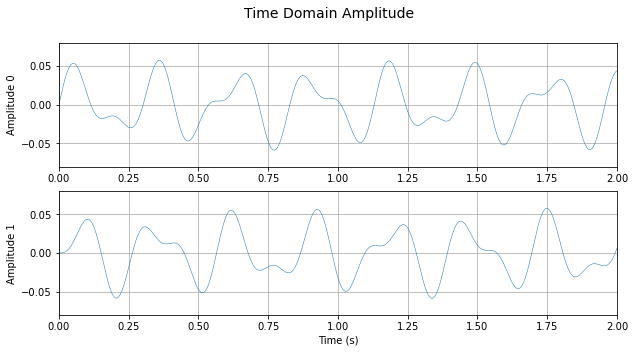

In [8]:
# Build the modal responses as harmonic functions with given properties
uk  = MRPy.harmonic(NX=2, N=N, fs=F1.fs, X0=u0k, f0=fk1, phi=thk)

# Calculate the NODAL responses superposing all modal responses
uN = MRPy(np.dot(Phi1, uk), fs=F1.fs)

f6  = uN.plot_time(6, figsize=(10,5), axis_t=[0, uN.Td, -0.08, 0.08])

up  = uN.max(axis=1)
print('Deslocamento de pico da massa 1 é {0:6.4f}m'.format(up[0]))
print('Deslocamento de pico da massa 2 é {0:6.4f}m'.format(up[1]))


Observa-se que a hipótese de aproximação como carga impulsiva é muito ruim, pois para o segundo modo:

$$\frac{t_{\rm d}}{T_{\rm n}} = 0.1{\rm s} \times 6.16{\rm Hz} = 0.616$$

e este valor é bem maior que o valor de 25% recomendado como limite para a aproximação. Além disso, deve-se considerar que a solução acima não considera o amortecimento.


## Questão 3

Todos os elementos do pórtico elástico linear tem rigidez à flexão 
$EI = 6.5{\rm kN m^2}$ e massa por unidade de comprimento $\mu = 20{\rm kg/m}$.
Viga e colunas tem o mesmo comprimento $L = 4{\rm m}$.
O amortecimento do sistema é $\zeta = 0.01$ (razão do crítico).
A aceleração da gravidade no local é $g = 9.81{\rm m/s^2}$.

<img src="resources/tests/PEC00025A_221_P2_Q3.jpg" alt="Question 3" width="480px"/>  


Proponha funções adequadas para representar uma geometria deformada que aproxime o
primeiro modo de vibração e estime a frequência fundamental de vibração livre através 
do quociente de Rayleigh. Lembre que as energias totais serão computadas somando-se
a contribuição dos três elementos estruturais.
_(Sugere-se o uso do software Ftool para o cálculo da energia interna de deformação.)_


### Solução

Fazendo-se o cálculo da estrutura acima no Ftool tem-se a seguinte deformada:

<img src="resources/tests/PEC00025A_221_P2_Q3_Ftool.png" alt="Análise pelo Ftool" width="360px"/>  

Os deslocamentos nos nós superiores, calculados com o Ftool com uma carga estática $F = 1{\rm kN}$, são:


In [9]:
uA =  0.590      # deslocamento da extremidade superior esquerda (m)
uB =  uA         # deslocamento da extremidade superior direita (m)

θA = -0.0894     # rotação da extremidade superior esquerda (rad)
θB = -0.0887     # rotação da extremidade superior direita (rad)


Estes valores podem ser interpolados utilizando as funções de interpolação dadas em aula, para termos uma expressão analítica para a linha elástica, com a qual pode-se calcular a energia de deformação e a energia cinética de referência.


In [10]:
# Dados do problema
L  = 4.           # comprimento das barras (m)
EI = 6500.        # rigidez à flexão (Nm2)
μ  = 20.          # massa por unidade de comprimento (kg/m)
F  = 1000.        # carga estática arbitrária aplicada (N)

# Discretização do comprimento das barras
x  = np.linspace(0, L, 200)
dx = L/200

# Lambda functions para interpolação dos deslocamentos
phi = []
phi.append(lambda xi:  1 - 3*xi*xi + 2*xi*xi*xi)
phi.append(lambda xi:  L*(xi - 2*xi*xi + xi*xi*xi))
phi.append(lambda xi:  3*xi*xi - 2*xi*xi*xi)
phi.append(lambda xi:  L*(-xi*xi + xi*xi*xi ))

# Lambda functions para interpolação das curvaturas
phixx = []
phixx.append(lambda xi: (-6 + 12*xi)/L/L) 
phixx.append(lambda xi: (-4 +  6*xi)/L  ) 
phixx.append(lambda xi: ( 6 - 12*xi)/L/L) 
phixx.append(lambda xi: (-2 +  6*xi)/L  ) 


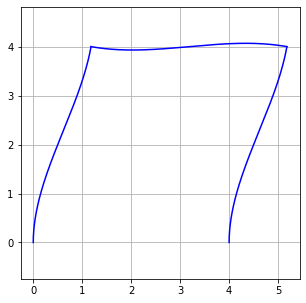

In [11]:
# Deslocamentos interpolados para as três barras

# coluna da esquerda (x de baixo pra cima)
w1 =  0*phi[0](x/L) +  0*phi[1](x/L) + uA*phi[2](x/L) - θA*phi[3](x/L)
# viga superior (x da esquerda para direita)
w2 =  0*phi[0](x/L) + θA*phi[1](x/L) +  0*phi[2](x/L) + θB*phi[3](x/L)
# coluna direita (x de baixo pra cima)
w3 =  0*phi[0](x/L) +  0*phi[1](x/L) + uB*phi[2](x/L) - θB*phi[3](x/L)

f7 = plt.figure(7, figsize=(5,5))
s  = 2   # escala das deformações

plt.plot(s*w1, x, 'b', s*uA + x, L + s*w2, 'b', L + s*w3, x, 'b')
plt.axis('equal')
plt.grid(True)


Esse conjunto de linhas deformadas será utilizado como forma modal para o cálculo da respectiva frequência natural
de vibração livre através do quociente de Rayleigh.

Observe que além dos deslocamentos transversais a cada barra, tem-se
também o deslocamento da viga para a direita, que representa a maior
parte da energia cinética do sistema!


In [12]:
# Energia cinética de referência

# Deslocamento da viga para a direita!
Tv = μ*L*(uA**2)/2     

# Deslocamentos transversais das três barras
Tr = Tv + μ*(np.trapz(w1**2 + w2**2 + w3**2, dx=dx))/2

print('A energia cinética de referência é {0:4.2f} J/m.'.format(Tr))
print('A massa da viga para a direita representa {0:3.1f}%.'.format(100*Tv/Tr))


A energia cinética de referência é 22.58 J/m.
A massa da viga para a direita representa 61.7%.


A energia potencial elástica pode ser calculada pelo trabalho da força externa:

In [13]:
# Trabalho da força externa
V  = F*uA/2

print('A energia potencial elástica é {0:4.1f} J.'.format(V))


A energia potencial elástica é 295.0 J.


E finalmente o cálculo pelo quociente de Rayleigh:

In [14]:
fn = np.sqrt(V/Tr)/(2*np.pi)

print('A frequência fundamental do pórtico é menor que {0:5.3f} Hz.'.format(fn))


A frequência fundamental do pórtico é menor que 0.575 Hz.


O cálculo da energia potencial elástica também pode ser feito pela curvatura:

In [15]:
# Curvaturas

w1xx =  0*phixx[0](x/L) +  0*phixx[1](x/L) + uA*phixx[2](x/L) - θA*phixx[3](x/L)
w2xx =  0*phixx[0](x/L) + θA*phixx[1](x/L) +  0*phixx[2](x/L) + θB*phixx[3](x/L)
w3xx =  0*phixx[0](x/L) +  0*phixx[1](x/L) + uB*phixx[2](x/L) - θB*phixx[3](x/L)

V    = EI*(np.trapz(w1xx**2 + w2xx**2 + w3xx**2, dx=dx))/2

print('A energia potencial elástica é {0:4.1f} J.'.format(V))


A energia potencial elástica é 295.5 J.


Que resulta muito próximo do valor calculado pelo trabalho das forças externas, respeitando portanto a conservação de energia.

## Questão 4

O topo do pórtico é submetido a uma força horizontal estocástica, $F(t)$, com densidade 
espectral $S_F(f)$, ilustrada abaixo. A força tem média zero e valor r.m.s. 
$\sigma_F = 50{\rm N}$. A banda de frequências excitada é definida por $r = 10$
(eixo das frequências em hertz). 

<img src="resources/tests/PEC00025A_221_P2_Q4.jpg" alt="Question 4" width="420px"/>  


Estime o valor r.m.s. e o valor de pico do deslocamento horizontal $u(t)$ na
extremidade esquerda da viga. Calcule a correspondente _força estática equivalente_.


### Solução

Inicialmente vamos calcular as propriedades modais no primeiro 
(e único) modo de vibração que foi estimado. Neste caso, a 
configuração deformada aproxima a forma modal, cuja escala vamos
manter com o deslocamento horizontal $u_A$ na extremidade esquerda 
da viga.

Definida essa escala para a forma modal, a massa modal iguala 
a energia cinética de referência sem o fator 1/2.


In [16]:
# Cálculo das propriedades modais

Mk = 2*Tr
wk = 2*np.pi*fn
Kk = wk*wk*Mk
zk = 0.01

# Deslocamento estático a partir da rigidez modal
Fk = 1000*uA      # força modal
uk = Fk/Kk        # deslocamento estático modal
ue = uA*uk        # deslocamento nodal

print('Massa modal:           {0:5.1f} kg.'.format(Mk))
print('Rigidez modal:         {0:4.1f} N/m.'.format(Kk))
print('Deslocamento estático: {0:5.3f} m.'.format(ue))


Massa modal:            45.2 kg.
Rigidez modal:         590.0 N/m.
Deslocamento estático: 0.590 m.


A força (definida pelo espectro) é aplicada na extremidade
esquerda da viga, na horizontal, onde o deslocamento na forma
modal tem amplitude $u_A$. Portanto o espectro da força modal é:


Amplitude r.m.s. pela integral do espectro é 50.0 N.



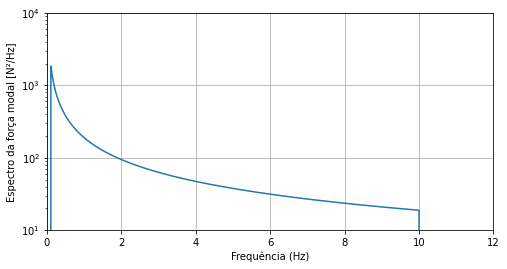

In [17]:
M  =  4097             # discretização do domínio da frequência
σF =  50               # valor r.m.s. da força
r  =  10.
f  =  np.linspace(0, 2*r, M)
fs =  2*f[-1]

SF =  np.zeros_like(f)

SF[f > 1/r] = (σF**2)/(2*np.log(r))*(1/f[f > 1/r])
SF[f < 1/r] =  0.
SF[f >  r ] =  0.

sF2 =  np.trapz(SF, f)
sF  =  np.sqrt(sF2)

print('Amplitude r.m.s. pela integral do espectro é {0:4.1f} N.\n'.format(sF))

SFk = uA*uA*SF      # espectro da força modal Fk(t)

plt.figure(3, figsize=(8,4), clear=True)
plt.semilogy(f, SFk);
plt.grid(True)
plt.axis([0, 1.2*r, 1e01, 1e04])
plt.xlabel('Frequência (Hz)')
plt.ylabel('Espectro da força modal [N²/Hz]');


Uma vez definido o espectro da força modal, podemos calcular a 
resposta modal no domínio da frequência.

O espectro do deslocamento NODAL (extremidade esquerda da viga)
é obtido multiplicando-se o espectro do deslocamento MODAL por 
$u_A^2$, da mesma forma como foi feito para a força modal.


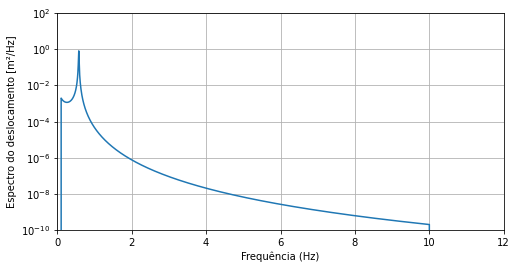

In [18]:
Hf2 =  lambda fi: 1/( (1 - (fi/fn)**2)**2 + (2*zk*(fi/fn))**2 )/(Kk**2)

SU  =  uA*uA*Hf2(f)*SFk

plt.figure(4, figsize=(8,4), clear=True)
plt.semilogy(f, SU);
plt.grid(True)
plt.axis([0, 1.2*r, 1e-10, 1e02])
plt.xlabel('Frequência (Hz)')
plt.ylabel('Espectro do deslocamento [m²/Hz]');


Finalmente, faz-se a análise estatística da resposta em deslocamento
a partir do espectro.


In [19]:
sU2 =  np.trapz(    SU, f)
sU4 =  np.trapz(f*f*SU, f)

nu  =  np.sqrt(sU4/sU2)
lnu =  np.sqrt(2*np.log(60*nu))  # Tempo de excitação é 60 segundos!
g   =  lnu + 0.5772/lnu

sU  =  np.sqrt(sU2)
up  =  g*sU

print('Fator de pico da resposta em deslocamento é    {0:6.2f}.'.format(g))
print('Amplitude r.m.s. da resposta em deslocamento é {0:4.0f}mm.'.format(1000*sU))
print('Valor de pico da resposta em deslocamento é    {0:4.0f}mm.'.format(1000*up))


Fator de pico da resposta em deslocamento é      2.87.
Amplitude r.m.s. da resposta em deslocamento é  123mm.
Valor de pico da resposta em deslocamento é     353mm.


Podemos usar a rigidez aparente da análise do Ftool para 
calcular a força estática equivalente. 


In [20]:
k   = 1000/uA
Feq = up*k

print('Força estática equivalente é {0:4.1f}N.'.format(Feq))


Força estática equivalente é 598.2N.
